In [1]:
from pathlib import Path
from typing import List
from math import sin, cos, sqrt, atan2, radians

import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

In [2]:
class BoundedUniformSampler:
    # Adapted from https://github.com/ServiceNow/seasonal-contrast/blob/main/datasets/seco_downloader.py

    def __init__(self, country_shapefile_path):
        self.boundaries = gpd.read_file(country_shapefile_path).loc[0, 'geometry']

    def sample_point(self) -> List[List]:
        '''
        Returns lon, lan from within a country.
        '''
        minx, miny, maxx, maxy = self.boundaries.bounds
        lon = np.random.uniform(minx, maxx)
        lat = np.random.uniform(miny, maxy)
        point = Point(lon, lat)
        if point.within(self.boundaries):
            return [point.x, point.y]
        else:
            return self.sample_point()
    
    def sample_n_points(self, n: int, buffer_km: float) -> gpd.GeoDataFrame:
        i = 0
        points = []
        while i < n:
            point = self.sample_point()
            too_close = self.check_distance_from_each_point(point[0], point[1], points, buffer_km=buffer_km)
            if not too_close:
                points.append(point)
                i += 1
        points = self.to_geodataframe(points)
        return points

    @staticmethod
    def to_geodataframe(points: List[List]) -> gpd.GeoDataFrame:
        '''Takes a list of list of lon/lat coordinates and converts it to a geopandas geodataframe.'''
        lon_lat = np.array(points)
        assert lon_lat.shape[1] == 2
        df = pd.DataFrame(lon_lat, columns=["lon", "lat"])
        return gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['lon'], df['lat']), crs="EPSG:4326")
    
    @staticmethod
    def save_geodataframe(gdf: gpd.GeoDataFrame, path: Path, overwrite: bool = False) -> None:
        if not path.exists():
            gdf.to_file(path)
        else:
            print(f'File with path {path} already exists!')
            if overwrite:
                print('Overwriting file.')
                gdf.to_file(path)

    @staticmethod
    def distance_between_two_points_km(lon1, lat1, lon2, lat2):
        # https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude
        R = 6373.0 # approximate radius of earth in km
        lat1 = radians(lat1)
        lon1 = radians(lon1)
        lat2 = radians(lat2)
        lon2 = radians(lon2)
        dlon = lon2 - lon1
        dlat = lat2 - lat1
        a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
        c = 2 * atan2(sqrt(a), sqrt(1 - a))
        distance = R * c

        return distance

    def check_distance_from_each_point(self, new_lon: float, new_lat: float, points: List[List[float]], buffer_km: float) -> bool:
        '''
        Returns True if new point is closer than the buffer distance (in km) from any point in points.
        ''' 
        for lon, lat in points:
            distance = self.distance_between_two_points_km(new_lon, new_lat, lon, lat)
            if distance < buffer_km:
                return True
        return False

In [4]:
path = Path('/home/gajo/DFS/Projects/2021-data-org/4._RESEARCH_n/ML/MLsatellite/Research/WP1_Joaquin/paper-nigeria-cropland/layers/nigeria_borders.shp')
sampler = BoundedUniformSampler(path)

In [4]:
N = 2000
points = sampler.sample_n_points(N, buffer_km=15)
sampler.save_geodataframe(points, path.parent / 'nigeria_stratified_v1.shp')

In [5]:
points

,lon,lat,geometry
0,7.169715,13.062977,POINT (7.16971 13.06298)
1,5.029259,9.861582,POINT (5.02926 9.86158)
2,11.673885,10.442239,POINT (11.67388 10.44224)
3,6.584187,6.506252,POINT (6.58419 6.50625)
4,7.099293,7.980531,POINT (7.09929 7.98053)
...,...,...,...
1995,13.412151,13.281881,POINT (13.41215 13.28188)
1996,3.703954,8.912081,POINT (3.70395 8.91208)
1997,4.971758,8.653739,POINT (4.97176 8.65374)
1998,12.565271,9.802278,POINT (12.56527 9.80228)


<AxesSubplot:>

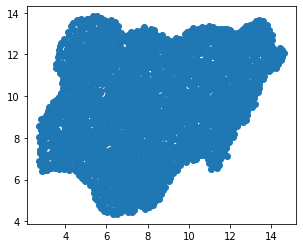

In [6]:
points.plot()